In [1]:
import torch
from torch.distributions import Normal
import math
import matplotlib.pyplot as plt

## Bayesian Inferencing for mean in Gaussian likelihood, known variance
Let us deal with a relatively simple case - where the variance of the parameters to be estimated is known and will be treated as a constant. The mean is unknown and modeled as a Gaussian random variable.

$$p\left(x^{ \left( i \right) } \middle\vert \mu \right) =  \frac{1}{{\sqrt {2\pi } \sigma}}e^{{\frac{ - \left( {x^{ \left( i \right) } - \mu } \right)^2 } {2\sigma ^2 }}}\\
p\left( X \middle\vert \mu \right) = \prod_{i=1}^{n} p\left(x^{ \left( 1 \right) }, x^{ \left( 2 \right) }, \cdots, x^{ \left( n \right) } \middle\vert \mu, \sigma \right) = 
\frac{1}{\left(\sqrt {2\pi } \sigma\right)^{n}} e^{{\frac{ -\sum_{i=1}^n \left( {x^{ \left( i \right) } - \mu } \right)^2 } {2\sigma ^2 }}}$$

The variance is known - hence it is  treated as a constant as opposed to a random variable. 


The mean $\mu$ is unknown and is treated as a random variable. This too is assumed to be a Gaussian, with mean $\mu_{0}$ and variance $\sigma_{0}$ (not to be confused with $\mu$ and $\sigma$ - the mean and variance of the data itself ). Hence, the prior is
$$p\left( \mu \right) =  \frac{1}{{\sqrt {2\pi } \sigma_{0}}}e^{{\frac{ - \left( { \mu - \mu_{0} } \right)^2 } {2\sigma_{0}^2 }}}$$


The posterior probability of the parameters

$$p \left( \mu \middle\vert X \right) = p \left( X \middle\vert \mu \right) p \left(  \mu \right) =  
   \frac{1}{ { \sqrt {2\pi } \sigma } } e^{ { \frac{ - \sum_{i=1}^n \left( {x^{ \left( i \right) } - \mu } \right)^2 } {2\sigma ^2 } } } 
   \;\;\;
   \frac{1}{ {\sqrt {2\pi } \sigma_{0} } } e^{ { \frac{ - \left( { \mu - \mu_{0} } \right)^2 } { 2\sigma_{0}^2 } } }$$
   
The right hand side is the product of two Gaussians, which is a Gaussian itself. Let us denote its mean and variance as $\mu_{n}$ and $\sigma_{n}$

$$\frac{1}{ \sigma_{n}^{2} } = \frac{1}{ \sigma_{0}^{2} } + \frac{ n }{ \sigma^{2} } \implies \sigma_{n}^{2}  = \frac{ \sigma_{0}^{2} \sigma^{2} }{ n \sigma_{0}^{2} + \sigma^{2} } $$
$$\mu_{n}= \frac{ \bar{x} } { 1 + \frac{\sigma^{2} }{ n \sigma_{0}^{2} } } + \frac{ \mu_{0} } { 1 + \frac{ n \sigma_{0}^{2} }{ \sigma^{2} } }$$

In [2]:
def inference_unknown_mean(X, prior_dist, sigma_known):
    mu_mle = X.mean()
    n = X.shape[0]
    
    # Parameters of the prior
    mu_0 = prior_dist.mean
    sigma_0 = prior_dist.scale
    
    # Parameters of posterior
    mu_n = mu_mle / (1 + sigma_known**2 / (n*sigma_0**2)) + mu_0 / (1 + n*sigma_0**2 / sigma_known**2) 
    sigma_n = math.sqrt((sigma_0**2 * sigma_known**2) / (n*sigma_0**2+sigma_known**2))
    posterior_dist = Normal(mu_n, sigma_n)
    return posterior_dist

In [3]:
def plot_distribution(dists, legend, true_mean, title):
    fig, ax = plt.subplots(dpi=400)
    ax.set_title(title)
    ax.set_ylabel("PDF(X)")
    ax.set_xlabel("X")
    y_lim = 0
    for dist in dists:
        x = torch.linspace(-100, 100, 10000)
        pdf = dist.log_prob(x).exp()
        ax.plot(x, pdf)
        y_lim = max(torch.max(pdf), y_lim)
    ax.plot([true_mean] * len(x) , x, '--')
    ax.set_xlim(-50, 100)
    ax.set_ylim(0, y_lim+0.01)
    legend.append("True Mean")
    ax.legend(legend)
    return ax

In [4]:
# Let us assume that the true distribution is a normal distribution. The true distribution corresponds 
# to a single class.
sigma_known = 20
true_dist = Normal(20, sigma_known)

In [5]:
# Let us assume our prior is a normal distribution with a large standard deviation. 
weak_prior = Normal(15, 10)

# Let us set a seed for reproducability
torch.manual_seed(42)

# Case 1.a
# Weak prior
# Number of samples is low. 
n = 3
X = true_dist.sample((n, 1))
posterior_dist_low_n = inference_unknown_mean(X, weak_prior, sigma_known)
likelihood_dist_low_n = Normal(X.mean(), sigma_known)

true_mean = true_dist.mean
mle_mean = likelihood_dist_low_n.mean
map_mean = posterior_dist_low_n.mean

# When n is low, the posterior is dominated by the prior. Thus, a good prior can help offset the lack of data.
# We can see this in the following case. 

# With a small sample (n=3), the MLE estimate of mean is  24.67, which is off from the true value of 20.00
# Using a good prior here helps offset it. The MAP estimate of mean (19.14) is much better. 

print(f"True mean: {true_mean:0.2f}")
print(f"MAP mean: {map_mean:0.2f}")
print(f"MLE mean: {mle_mean:0.2f}")

True mean: 20.00
MAP mean: 19.14
MLE mean: 24.67


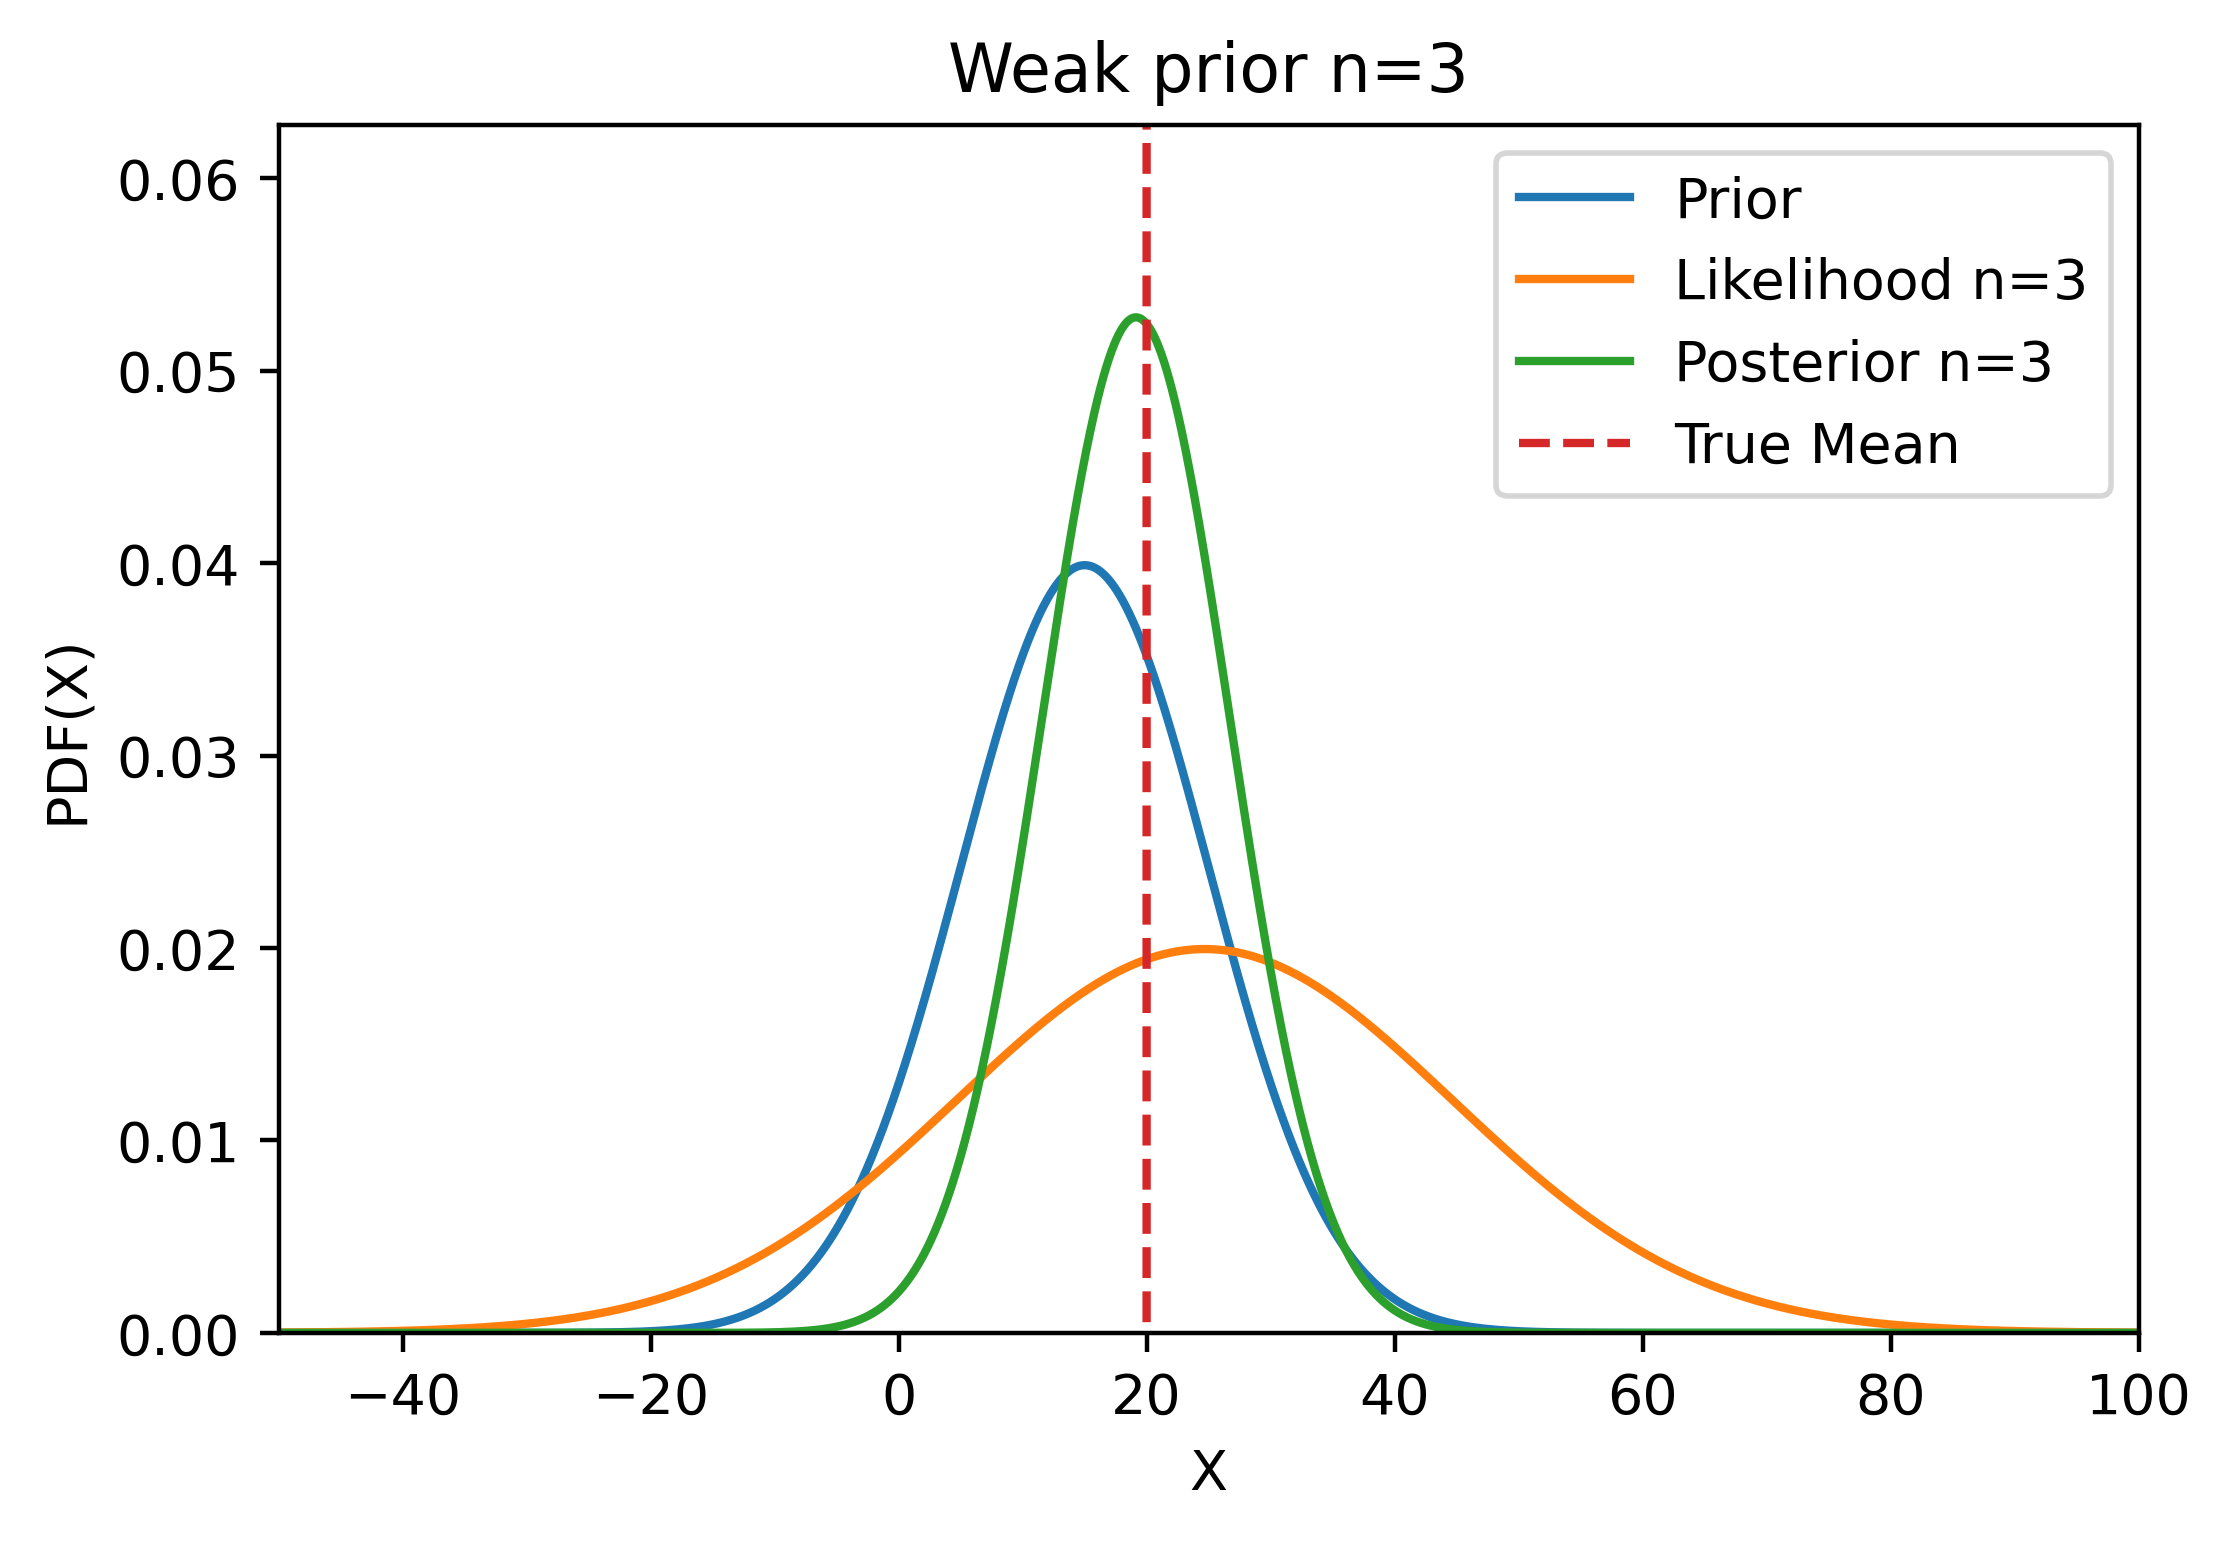

In [6]:
dists = [weak_prior, likelihood_dist_low_n, posterior_dist_low_n]
legend = ["Prior", "Likelihood n=3", "Posterior n=3"]
plot_distribution(dists, legend, true_dist.mean, "Weak prior n=3")
plt.show()

In [7]:
# Case 1.b
# Weak prior
# Number of samples is high. 
n = 100
X = true_dist.sample((n, 1))
posterior_dist_high_n = inference_unknown_mean(X, weak_prior, sigma_known)
likelihood_dist_high_n = Normal(X.mean(), sigma_known)

true_mean = true_dist.mean
mle_mean = likelihood_dist_high_n.mean
map_mean = posterior_dist_high_n.mean

# When n is high, the MLE tends to converge to the true distribution. The MAP also tends to converge to the MLE, 
# and in turn converges to the true distribution

print(f"True mean: {true_mean:0.2f}")
print(f"MAP mean: {map_mean:0.2f}")
print(f"MLE mean: {mle_mean:0.2f}")

True mean: 20.00
MAP mean: 21.46
MLE mean: 21.72


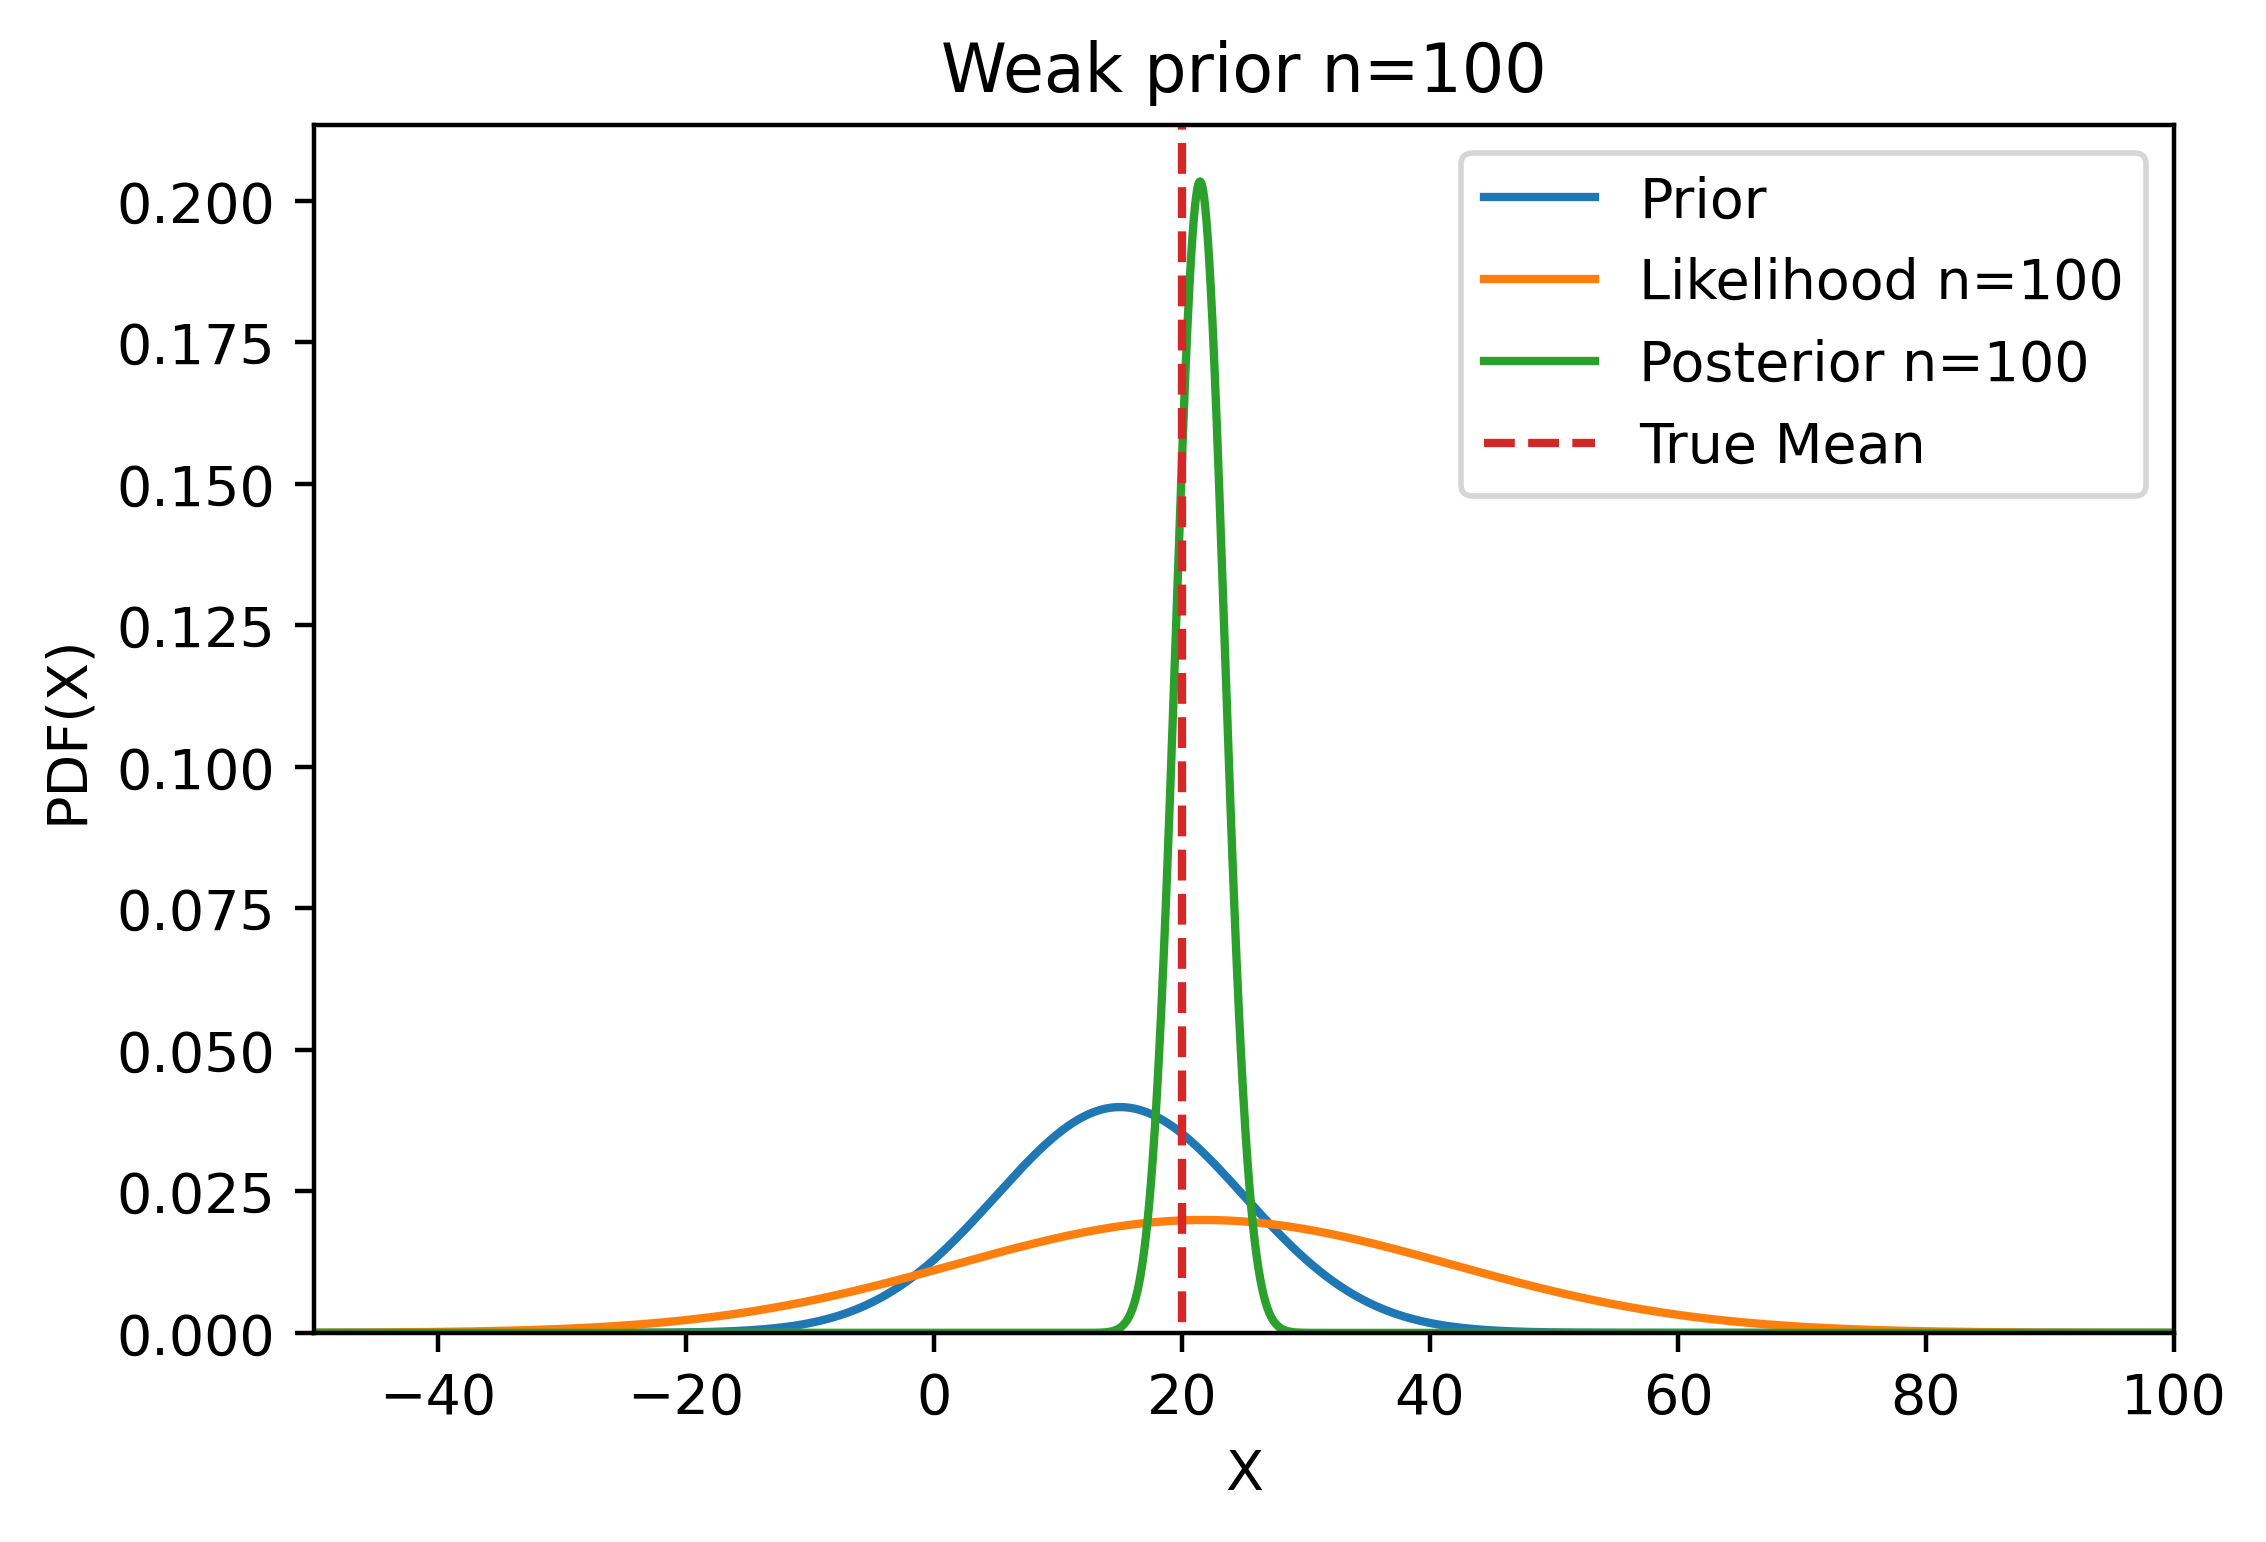

In [8]:
dists = [weak_prior, likelihood_dist_high_n, posterior_dist_high_n]
legend = ["Prior", "Likelihood n=100", "Posterior n=100"]
plot_distribution(dists, legend, true_dist.mean, "Weak prior n=100")
plt.show()

In [9]:
# Let us assume our prior is a normal distribution with a small standard deviation.
# We are intentionally choosing a bad strong prior to demonstrate how strong priors cannot easily be overwhelmed 
# by data.
strong_prior = Normal(15, 1)

# Let us set a seed for reproducability
torch.manual_seed(42)

# Case 2a
# Strong prior
# Number of samples is low. 
n = 3
X = true_dist.sample((n, 1))
posterior_dist_low_n = inference_unknown_mean(X, strong_prior, sigma_known)
likelihood_dist_low_n = Normal(X.mean(), sigma_known)

true_mean = true_dist.mean
mle_mean = likelihood_dist_low_n.mean
map_mean = posterior_dist_low_n.mean

# When n is low, the posterior is dominated by the prior. With a strong prior, the posterior is much more 
# closer to the prior than the MLE

# With a small sample (n=3), the MLE estimate of mean is 24.67, which is off from the true value of 20.00
# The MAP estimate of mean, 15.07), is much more closer to the prior , 15.0. 

print(f"True mean: {true_mean:0.2f}")
print(f"MAP mean: {map_mean:0.2f}")
print(f"MLE mean: {mle_mean:0.2f}")

True mean: 20.00
MAP mean: 15.07
MLE mean: 24.67


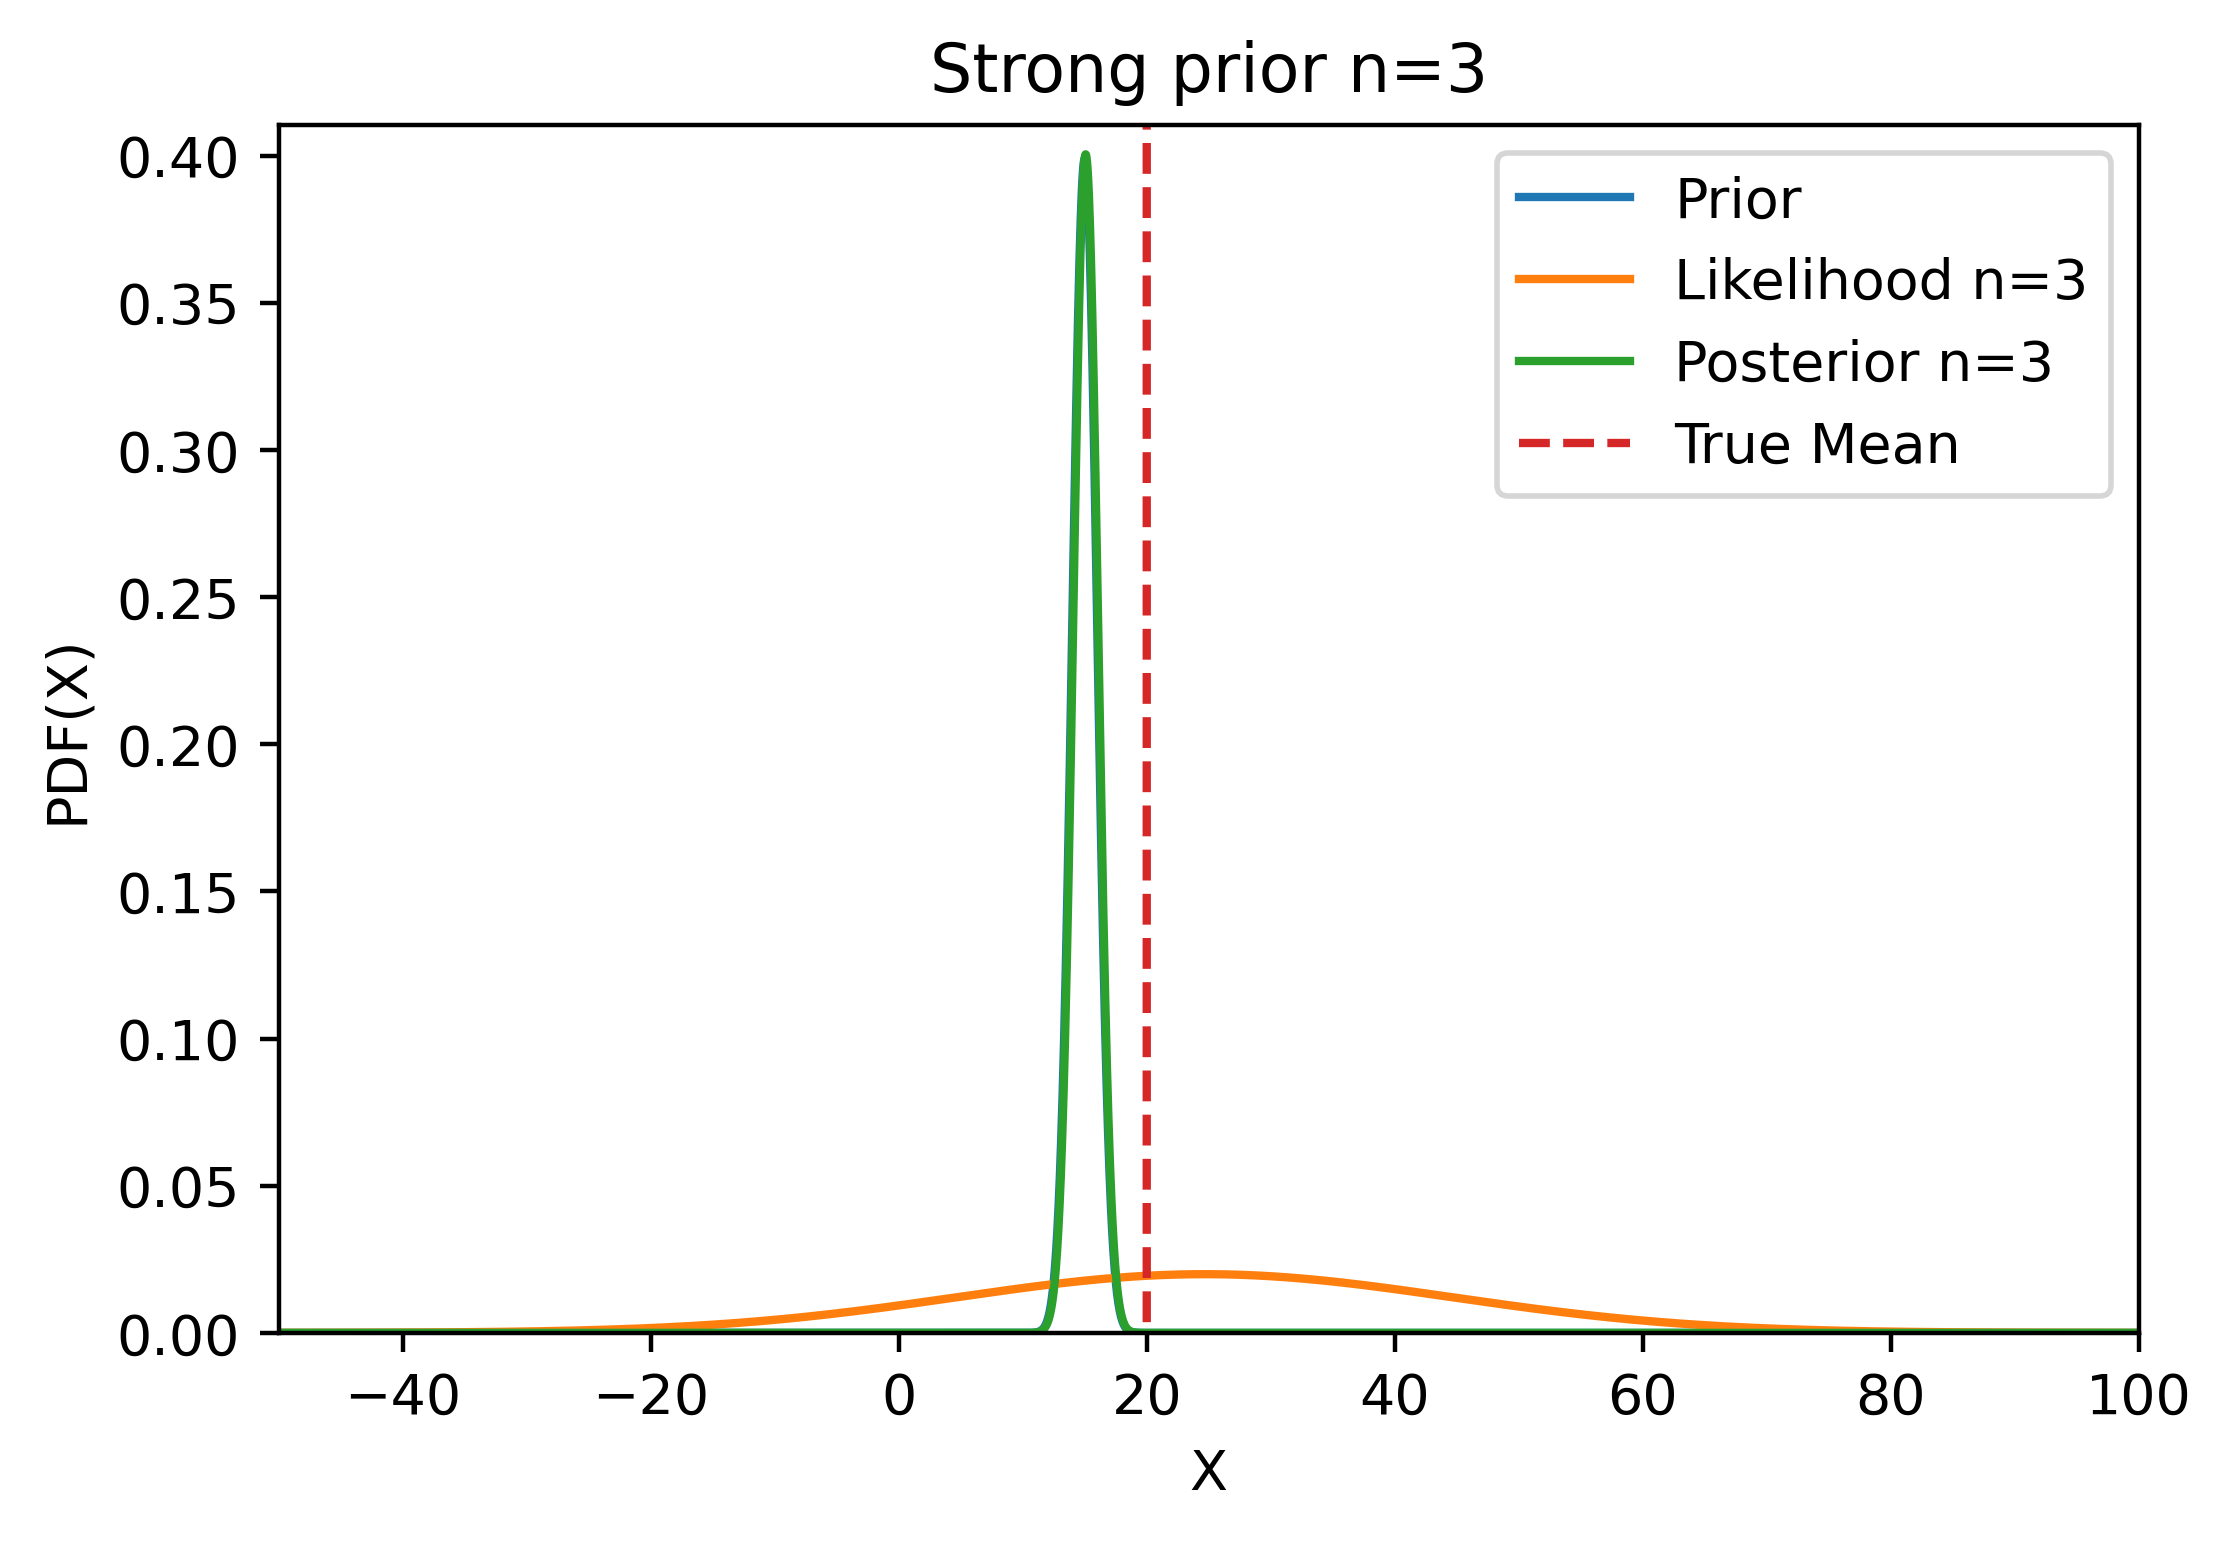

In [10]:
dists = [strong_prior, likelihood_dist_low_n, posterior_dist_low_n] 
legend = ["Prior", "Likelihood n=3", "Posterior n=3"]
plot_distribution(dists, legend, true_dist.mean, "Strong prior n=3")
plt.show()

In [11]:
# Number of samples is high. 
n = 100
X = true_dist.sample((n, 1))
posterior_dist_high_n = inference_unknown_mean(X, strong_prior, sigma_known)
likelihood_dist_high_n = Normal(X.mean(), sigma_known
                               )

true_mean = true_dist.mean
mle_mean = likelihood_dist_high_n.mean
map_mean = posterior_dist_high_n.mean

# With a strong prior, it is difficult to overwhelm it by data. This can be seen below

# With a large sample (n=100), the MLE estimate of mean is 21.72 which is close to the the true mean of 20.00
# The MAP estimate of mean, 16.34 is still closer to the prior, 15.0. So even a large sample hasn't overwhelmed 
# the estimate of the posterior

print(f"True mean: {true_mean:0.2f}")
print(f"MAP mean: {map_mean:0.2f}")
print(f"MLE mean: {mle_mean:0.2f}")

True mean: 20.00
MAP mean: 16.34
MLE mean: 21.72


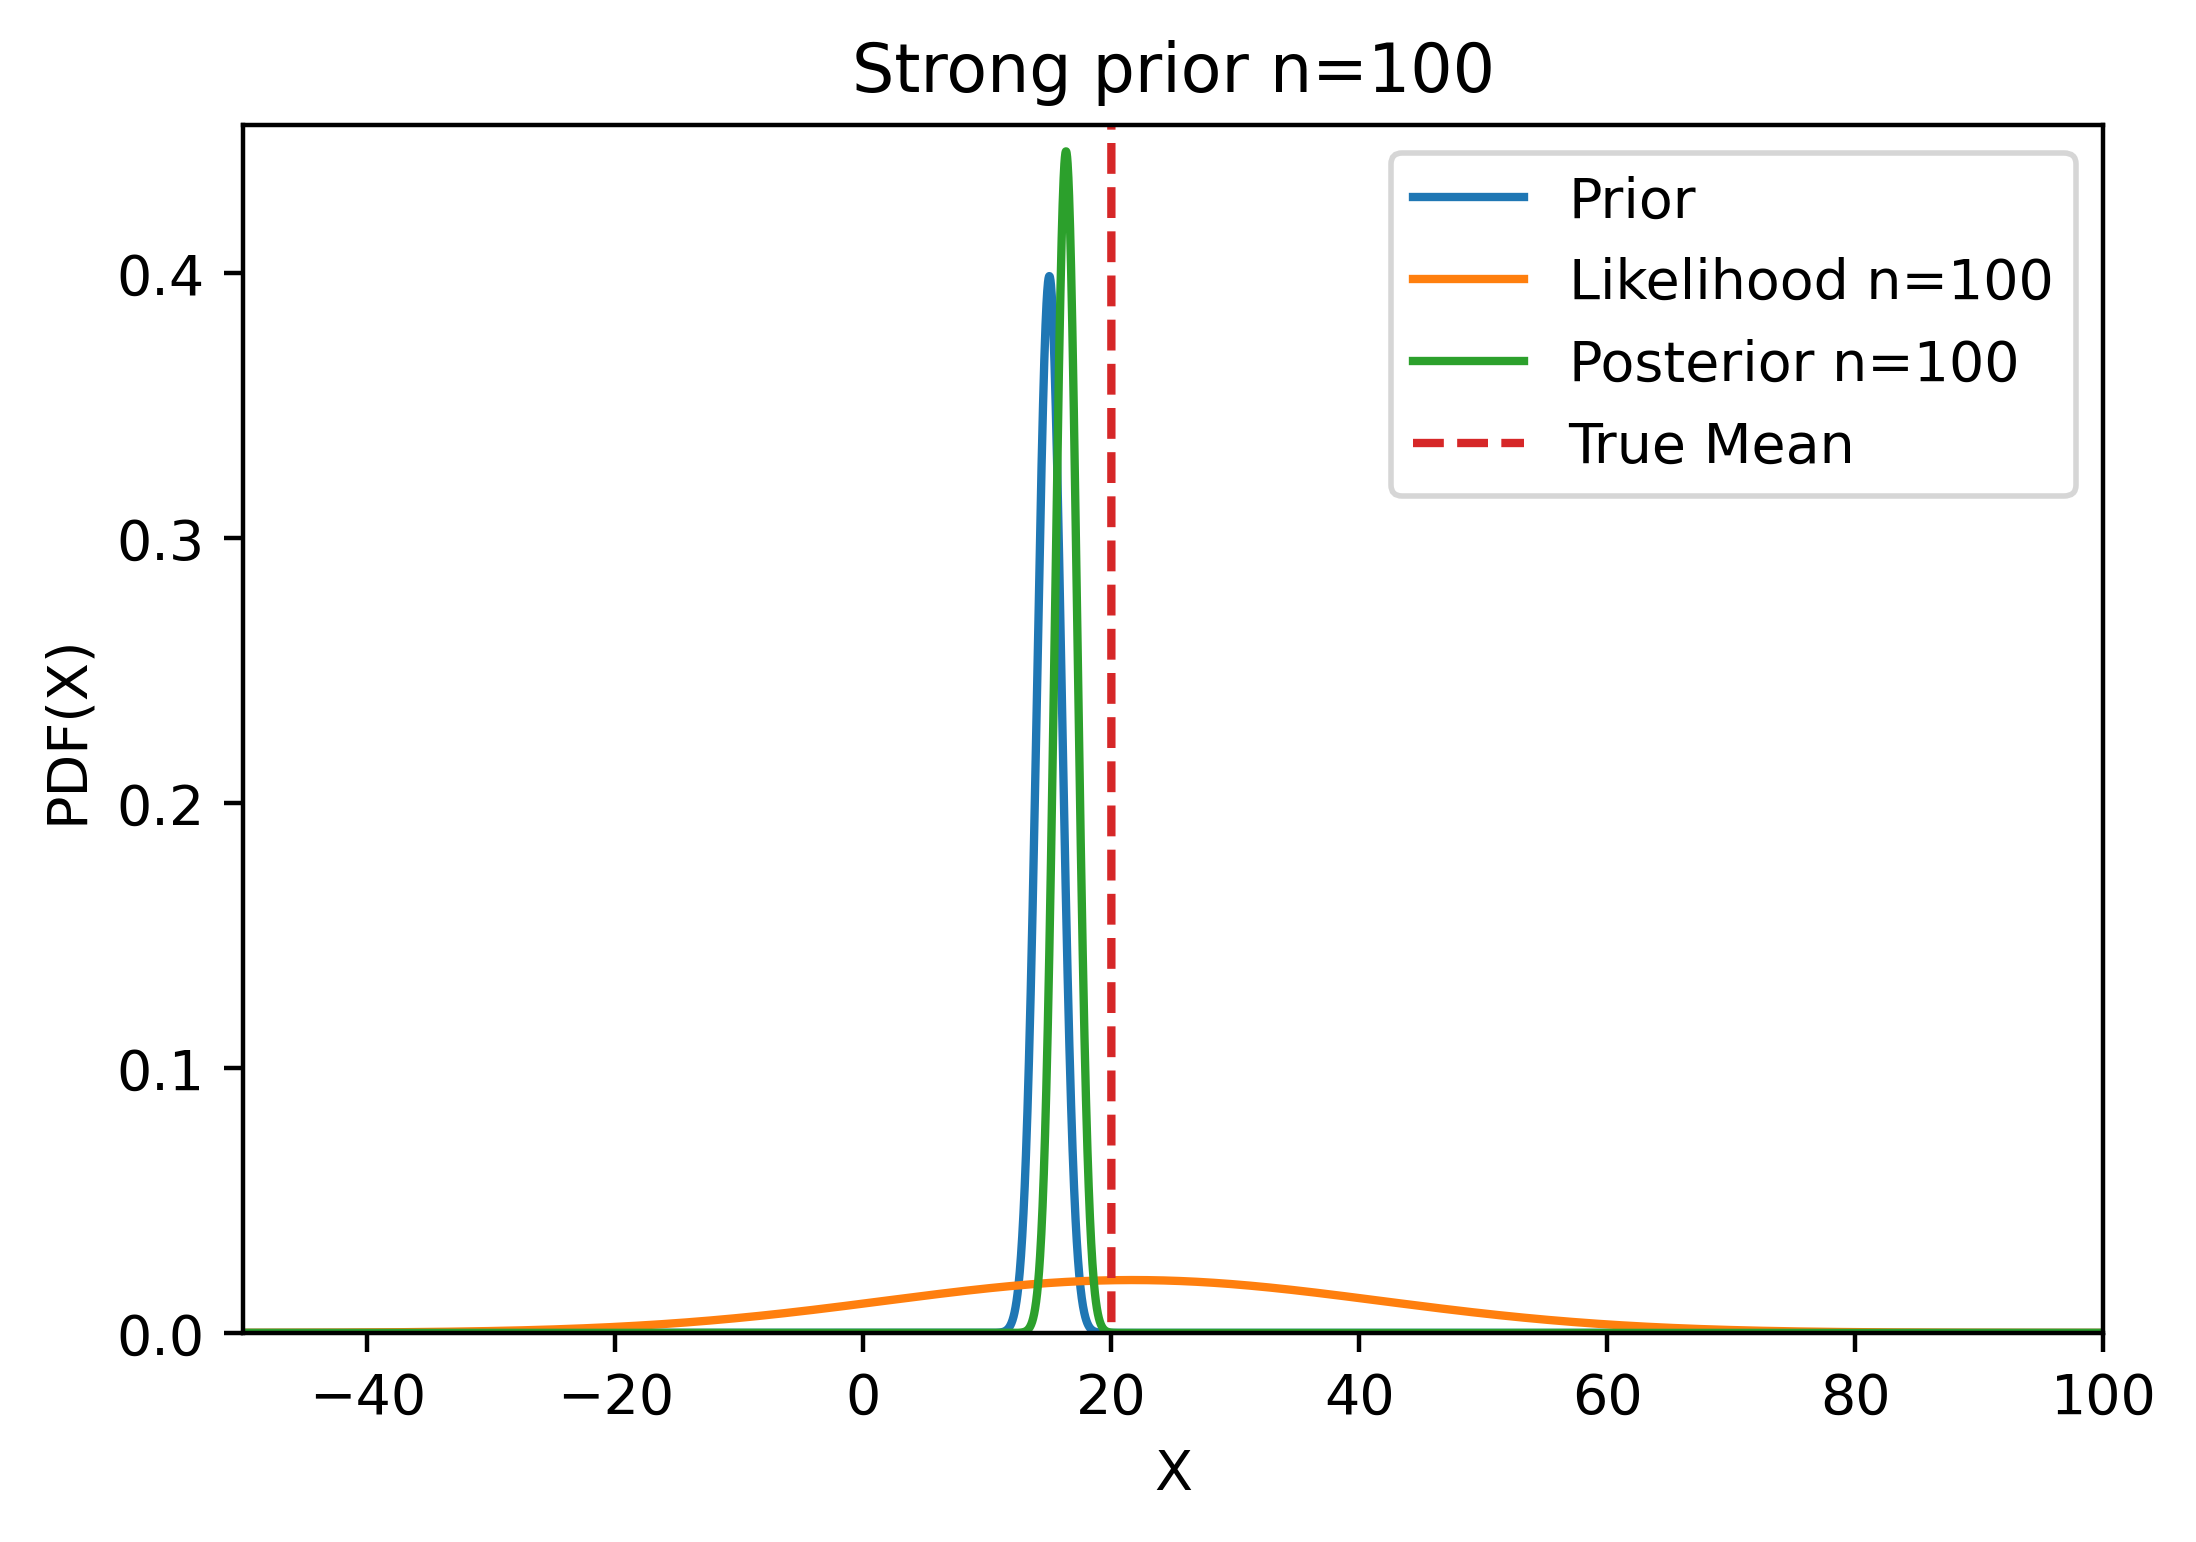

In [12]:
dists = [strong_prior, likelihood_dist_high_n, posterior_dist_high_n]
legend = ["Prior", "Likelihood n=100", "Posterior n=100"]
plot_distribution(dists, legend, true_dist.mean, "Strong prior n=100")
plt.show()

### How to use the estimated mean parameter?

We typically find $\mu_{∗}$, the value of $\mu$ that maximizes this posterior probability. In this particular case, the maxima of a Gaussian probability density occurs at the mean, hence, $\mu_{∗}$ = $\mu_{n}$.

Given an arbitrary new data instance $x$, its probability of belonging to the class from which the training data has been sampled is $\mathcal{N}\left( x; \mu_{n}, \sigma \right)$.


In [13]:
map_dist = Normal(posterior_dist_high_n.mean, sigma_known)
print(f"MAP distribution mu: {map_dist.mean:0.2f} std:{map_dist.scale}")

MAP distribution mu: 16.34 std:20.0
